In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
FOLDERNAME = 'DP/data/'
if FOLDERNAME is None: FOLDERNAME = input("[!] Enter folder name: ")

os.chdir(f'/content/drive/MyDrive/Colab Notebooks/{FOLDERNAME}')

Mounted at /content/drive


# Base model

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import cv2
import math

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
!pip install torchinfo

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchinfo import summary

In [3]:
os.listdir()

['.DS_Store',
 'nb.ipynb',
 'pytorch.ipynb',
 'unet.ipynb',
 'tensorflow.ipynb',
 'nb2.ipynb',
 'test.ipynb',
 'wandb']

In [4]:
data_path = '../../BP/data/BraTS2021/train/BraTS2021_00002/'
os.listdir(data_path)

['BraTS2021_00002_t2.nii.gz',
 'BraTS2021_00002_seg.nii.gz',
 '.DS_Store',
 'BraTS2021_00002_t1.nii.gz',
 'BraTS2021_00002_flair.nii.gz',
 'BraTS2021_00002_t1ce.nii.gz']

In [5]:
t1_list = [os.path.join(data_path, 'BraTS2021_00002_t1ce.nii.gz')]
t2_list = [os.path.join(data_path, 'BraTS2021_00002_t2.nii.gz')]
seg_list = [os.path.join(data_path, 'BraTS2021_00002_seg.nii.gz')]

In [6]:
print(len(t1_list), len(t2_list), len(seg_list))

print(t1_list)
print(t2_list)
print(seg_list)

1 1 1
['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz']
['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t2.nii.gz']
['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_seg.nii.gz']


In [7]:
t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = t1_list, t1_list, t2_list, t2_list, seg_list, seg_list

In [8]:
print(len(t1_train), len(t2_train), len(seg_train))
print(len(t1_val), len(t2_val), len(seg_val))

print('t1_train:', t1_train[:3])
print('t2_train: ', t2_train[:3])
print('seg_train: ', seg_train[:3])
print()
print('t1_val: ', t1_val[:3])
print('t2_val', t2_val[:3])
print('seg_val', seg_val[:3])

1 1 1
1 1 1
t1_train: ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz']
t2_train:  ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t2.nii.gz']
seg_train:  ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_seg.nii.gz']

t1_val:  ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t1ce.nii.gz']
t2_val ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_t2.nii.gz']
seg_val ['../../BP/data/BraTS2021/train/BraTS2021_00002/BraTS2021_00002_seg.nii.gz']


## Data generator

In [9]:
def get_glioma_indices(mask):
  first = torch.nonzero((mask == 1))[:,1][0].item()
  last = torch.nonzero((mask == 1))[:,1][-1].item()

  return first, last

In [10]:
# https://arxiv.org/abs/2011.01045
# https://github.com/lescientifik/open_brats2020/tree/main
def normalize(image):
    """ Basic min max scaler. """
    min_ = torch.min(image)
    max_ = torch.max(image)
    scale = max_ - min_
    image = (image - min_) / scale
    return image

In [11]:
class MRIDataset(Dataset):
    def __init__(self, t1_list, t2_list, seg_list, img_dims):
        self.t1_list = t1_list
        self.t2_list = t2_list
        self.seg_list = seg_list
        self.img_dims = img_dims

    def __len__(self):
      return len(self.t1_list)

    def _get_glioma_indices(self, mask):
      first = torch.nonzero((mask == 1))[:,0][0].item()
      last = torch.nonzero((mask == 1))[:,0][-1].item()

      return first, last

    def _crop_depth(self, mask):
      first, last = self._get_glioma_indices(mask)
      range_length = last - first + 1

      # print(f'old indices: {first}, {last} : {first - last}')

      # compute the desired padding size on both sides
      padding_size = self.img_dims[0] - range_length
      padding_size_left = math.floor(padding_size / 2)
      padding_size_right = math.ceil(padding_size / 2)

      # compute the new start and end indices of the cropped depth dimension
      mid_index = (first + last) // 2
      start_index = max(mid_index - math.floor(self.img_dims[0] / 2), 0)
      end_index = min(start_index + self.img_dims[0], mask.shape[0])

      # crop the volume along the depth dimension
      # cropped_volume = volume[start_index:end_index,:,:]

      return start_index, end_index

    def _normalise(self, volume):
      # mean = torch.mean(volume, dim=(0, 1, 2), keepdim=True)
      # sd = torch.std(volume, dim=(0, 1, 2), keepdim=True)
      # return (volume - mean) / sd
      # return irm_min_max_preprocess(volume)
      return normalize(volume)

    def __getitem__(self, idx):
      t1 = torch.as_tensor(nib.load(self.t1_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
      t2 = torch.as_tensor(nib.load(self.t2_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
      seg = torch.as_tensor(nib.load(self.seg_list[idx]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
      seg[seg == 1] = 0
      seg[seg == 4] = 0
      seg[seg == 2] = 1

      # print('old shapes: ', t1.shape, t2.shape, seg.shape)

      t1 = TF.center_crop(t1, (self.img_dims[1]*2, self.img_dims[2]*2))
      t2 = TF.center_crop(t2, (self.img_dims[1]*2, self.img_dims[2]*2))
      seg = TF.center_crop(seg, (self.img_dims[1]*2, self.img_dims[2]*2))

      if t1.shape[0] > self.img_dims[0]:
        start_index, end_index = self._crop_depth(seg)
        t1 = t1[start_index:end_index,:,:]
        t2 = t2[start_index:end_index,:,:]
        seg = seg[start_index:end_index,:,:]
        # print(t1.shape[0], t2.shape[0], seg.shape[0])

        first, last = self._get_glioma_indices(seg)
        # print(f'new indices: {first}, {last} : {first - last}')

      elif t1.shape[0] < self.img_dims[0]:
        pad = (0, 0, 0, 0, (self.img_dims[0]-t1.shape[0])//2, (self.img_dims[0]-t1.shape[0])//2)
        t1 = F.pad(t1, pad, "constant", 0)
        t2 = F.pad(t2, pad, "constant", 0)
        seg = F.pad(seg, pad, "constant", 0)
        # print(t1.shape[0], t2.shape[0], seg.shape[0])

      t1 = TF.resize(t1, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
      t2 = TF.resize(t2, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)
      seg = TF.resize(seg, (self.img_dims[1], self.img_dims[2]), interpolation=TF.InterpolationMode.NEAREST, antialias=False)

      t1 = self._normalise(t1)
      t2 = self._normalise(t2)

      stacked = torch.stack((t1, t2), axis=0)
      seg = seg.unsqueeze(0)

      return stacked, seg

In [12]:
combined_t1 = t1_train + t1_val
combined_t2 = t2_train + t2_val
combined_seg = seg_train + seg_val

print(len(combined_t1), len(combined_t2), len(combined_seg))

2 2 2


### Testing data generator

In [13]:
seg = torch.as_tensor(nib.load(combined_seg[0]).get_fdata(), dtype=torch.float32).permute(2, 0, 1)
seg.shape

torch.Size([155, 240, 240])

In [14]:
seg[seg == 1] = 0
seg[seg == 4] = 0
torch.unique(seg.unsqueeze(0)[0])

tensor([0., 2.])

#### 40x80x80

In [15]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 80, 80))

In [16]:
img, label = data[0]
print(img.shape, label.shape)
print(img.dtype, label.dtype)

torch.Size([2, 40, 80, 80]) torch.Size([1, 40, 80, 80])
torch.float32 torch.float32


Text(0.5, 1.0, 'Segmentation')

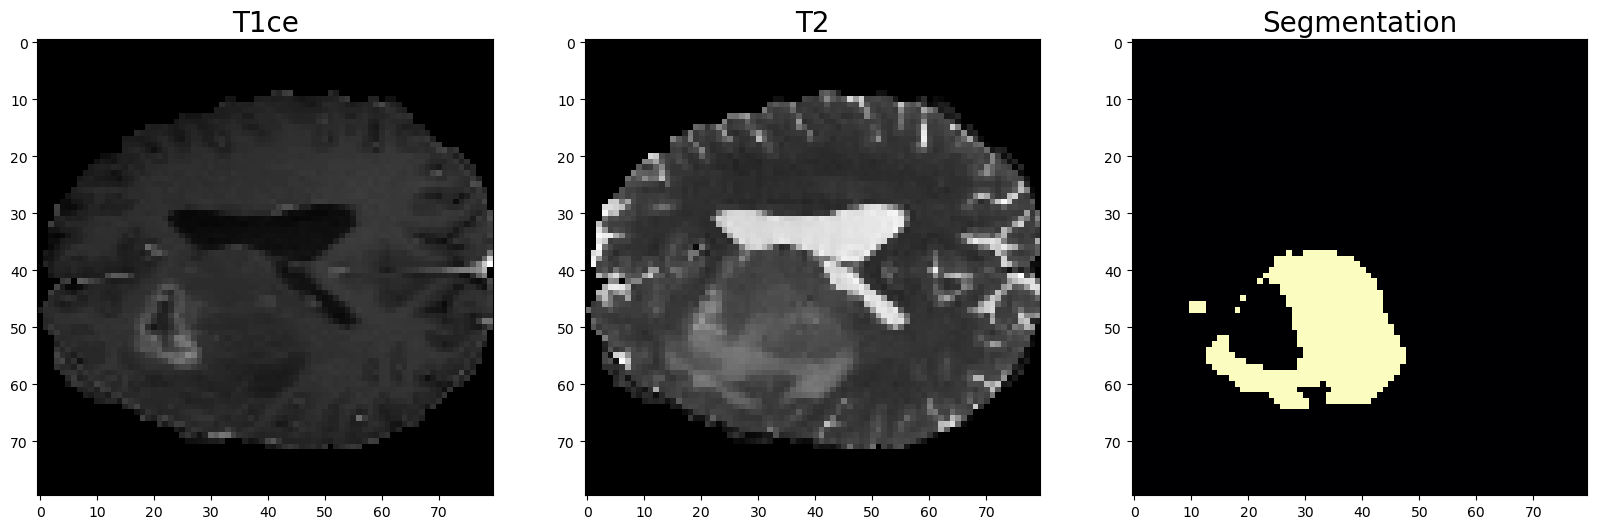

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
slice = 39
axs[0].imshow(x[0,slice,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,slice,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,slice,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 40x128x128

Text(0.5, 1.0, 'Segmentation')

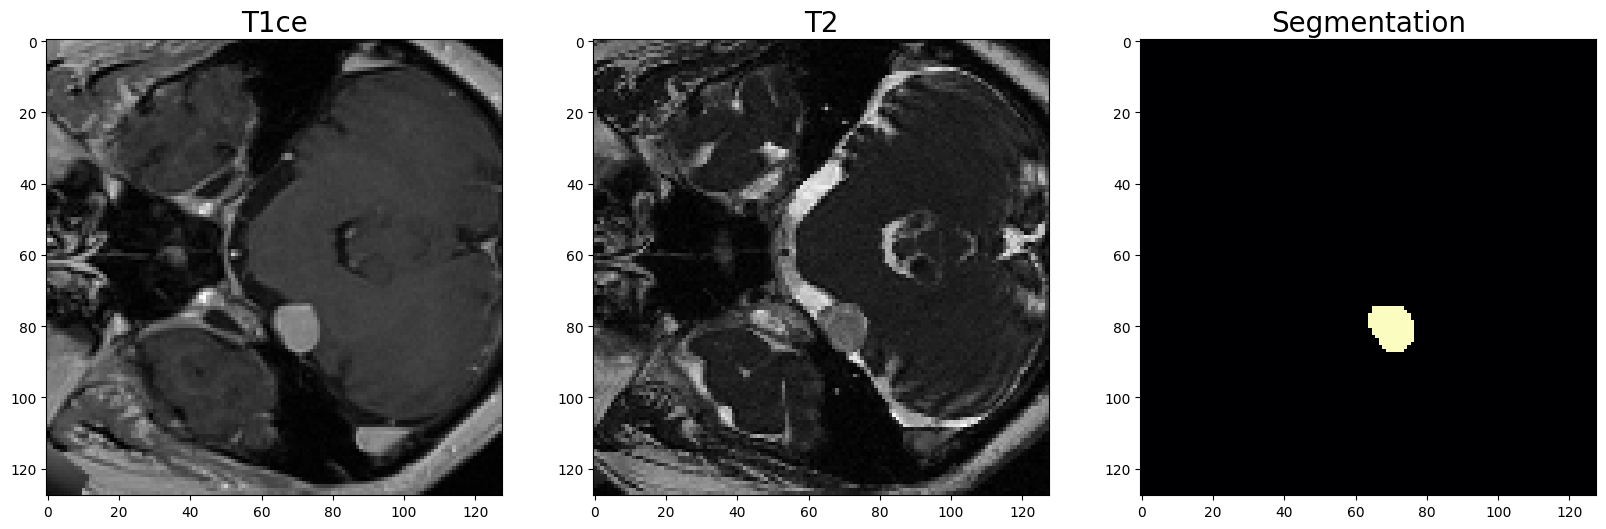

In [29]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 128, 128))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

#### 40x40x40

Text(0.5, 1.0, 'Segmentation')

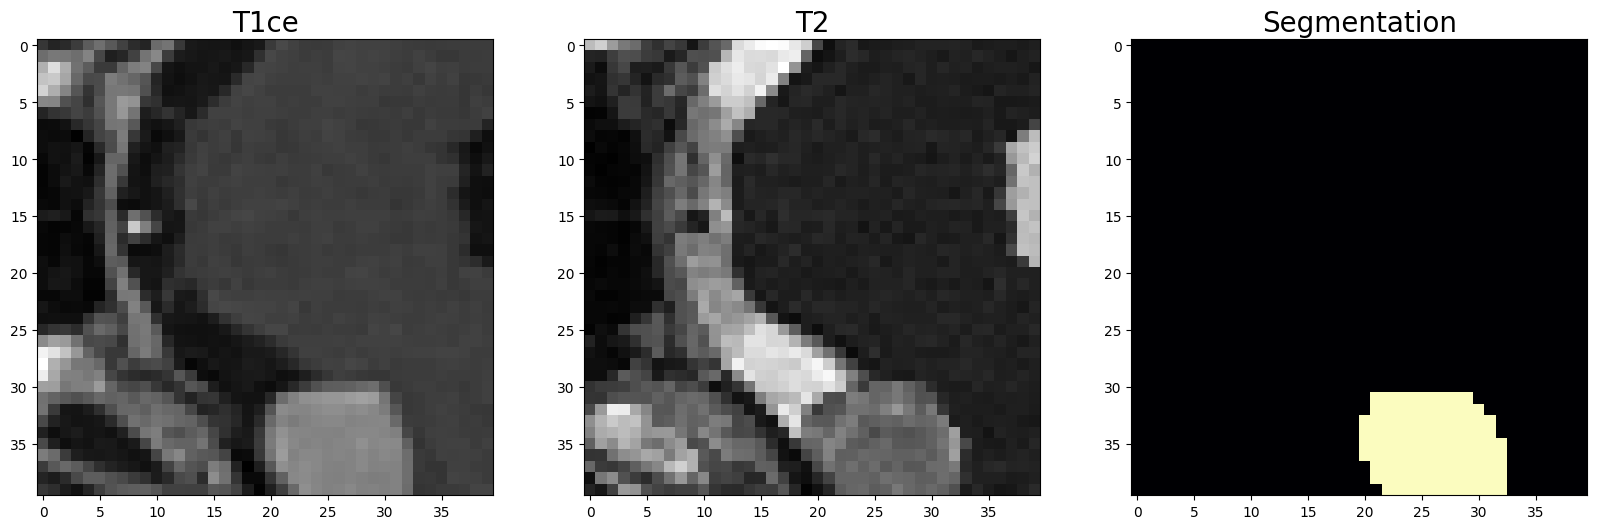

In [30]:
# transform = transforms.Compose([transforms.Resize((256, 256), antialias=False)])
data = MRIDataset([t1_train[0]], [t2_train[0]], [seg_train[0]], (40, 40, 40))

fig, axs = plt.subplots(1, 3, figsize=(20, 20))
x, y = data[0]
axs[0].imshow(x[0,20,:,:], cmap='gray')
# axs[0].axis('off')
axs[0].set_title('T1ce', fontsize=20)
axs[1].imshow(x[1,20,:,:], cmap='gray')
# axs[1].axis('off')
axs[1].set_title('T2', fontsize=20)
axs[2].imshow(y[0,20,:,:], cmap='magma')
# axs[2].axis('off')
axs[2].set_title('Segmentation', fontsize=20)

### Class weights

In [35]:
def get_class_count(seg):
  labels, counts = torch.unique(seg[0], return_counts=True)
  print(counts)
  print((counts[1]/counts[0]).item())


#### 40x128x128

In [25]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 128, 128))

In [ ]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y[0], return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

In [22]:
# {0: 164753098, 1: 397622}
classes = {0: 164753098, 1: 397622}
classes[1] / classes[0]

0.0024134417187105035

In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  get_class_count(y)

#### 40x80x80

In [37]:
data = MRIDataset(t1_train, t2_train, seg_train, (40, 80, 80))

In [45]:
classes = {0: 0, 1: 0}
for i in range(len(data)):
  x, y = data[i]
  labels, counts = torch.unique(y, return_counts=True)
  classes[0] += counts[0].item()
  classes[1] += counts[1].item()
  print(i, classes)

0 {0: 228129, 1: 27871}


In [42]:
# {0: 64115061, 1: 396939}
classes = {0: 228129, 1: 27871}
print(classes[1] / classes[0])
print(classes[0] / classes[1])

0.12217210437953965
8.185174554196118


In [ ]:
for i in range(len(data)):
  print('==========')
  print(f'scan: {i}')
  x, y = data[i]
  print('shapes: ', x[0].shape, x[1].shape, y[0].shape)
  classes[0] +
  get_class_count(y)

### Union over masks

In [122]:
data = MRIDataset(combined_t1, combined_t2, combined_seg, (40, 80, 80))

In [123]:
masks_combined = torch.zeros((40, 80, 80))

In [124]:
for i in range(len(data)):
  print(f'scan: {i}')
  _, y = data[i]
  masks_combined += y[0]

# i = 0
# for (_, mask) in data_gen:
#   mask = mask[0, :, :, :, 0]
#   masks_combined += mask
#   i += 1
#   if i%10==0: print(i)
# i

scan: 0
scan: 1


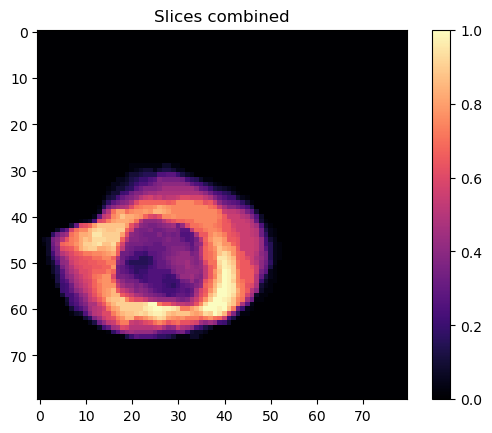

In [125]:
summed = torch.sum(masks_combined, axis=0)
a = summed / summed.max()

plt.imshow(a, cmap='magma')
plt.title('Slices combined')
cb = plt.colorbar()
plt.show()

## Model

In [12]:
def build_conv_block(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv3d(in_channels[0], out_channels[0], kernel_size=3, padding=1, padding_mode='zeros'),
      nn.ReLU(),
      nn.Conv3d(in_channels[1], out_channels[1], kernel_size=3, padding=1, padding_mode='zeros'),
      nn.ReLU(),
      )


class DownBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[0], out_channels[1]])
    self.down = nn.MaxPool3d(kernel_size=2)

  def forward(self, x):
    out = self.conv(x)
    downscaled = self.down(out)

    return out, downscaled

class UpBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose3d(in_channels=in_channels[0], out_channels=out_channels[0], kernel_size=2, stride=2)
    # self.up = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
    self.conv = build_conv_block(in_channels=[in_channels[0], in_channels[1]], out_channels=[out_channels[1], out_channels[1]])

  def forward(self, x, skip):
    upscaled = self.up(x)
    # print(upscaled.shape, skip.shape)
    concat = torch.cat([skip, upscaled], dim=1)
    # print(concat.shape)
    out = self.conv(concat)
    # print(out.shape)

    # print()
    return out

class Unet(nn.Module):
  def __init__(self):
      super().__init__()
      self.down1 = DownBlock(in_channels=[2, 32], out_channels=[32, 32])
      self.down2 = DownBlock(in_channels=[32, 64], out_channels=[64, 64])
      self.down3 = DownBlock(in_channels=[64, 128], out_channels=[128, 128])
      # self.down4 = DownBlock(in_channels=[64, 128], out_channels=[128, 128])

      self.bottle_neck = build_conv_block(in_channels=[128, 256], out_channels=[256, 256])

      # self.up1 = UpBlock(in_channels=[256, 128], out_channels=[128, 128])
      self.up2 = UpBlock(in_channels=[256, 128], out_channels=[128, 128])
      self.up3 = UpBlock(in_channels=[128, 64], out_channels=[64, 64])
      self.up4 = UpBlock(in_channels=[64, 32], out_channels=[32, 32])

      self.output = nn.Sequential(
          nn.Conv3d(in_channels=32, out_channels=1, kernel_size=1),
          nn.Sigmoid()
      )

  def forward(self, x):
    # Contracting path
    skip1, down1 = self.down1(x)
    skip2, down2 = self.down2(down1)
    skip3, down3 = self.down3(down2)
    # skip4, down4 = self.down4(down3)

    # Bottle neck
    bottom = self.bottle_neck(down3)

    # Expanding path
    # up1 = self.up1(bottom, skip4)
    up2 = self.up2(bottom, skip3)
    up3 = self.up3(up2, skip2)
    up4 = self.up4(up3, skip1)

    # Output
    out = self.output(up4)

    return out

# model = Unet()
# model

In [13]:
summary(Unet(), input_size=(2, 2, 40, 80, 80))

Layer (type:depth-idx)                   Output Shape              Param #
Unet                                     [2, 1, 40, 80, 80]        --
├─DownBlock: 1-1                         [2, 32, 40, 80, 80]       --
│    └─Sequential: 2-1                   [2, 32, 40, 80, 80]       --
│    │    └─Conv3d: 3-1                  [2, 32, 40, 80, 80]       1,760
│    │    └─ReLU: 3-2                    [2, 32, 40, 80, 80]       --
│    │    └─Conv3d: 3-3                  [2, 32, 40, 80, 80]       27,680
│    │    └─ReLU: 3-4                    [2, 32, 40, 80, 80]       --
│    └─MaxPool3d: 2-2                    [2, 32, 20, 40, 40]       --
├─DownBlock: 1-2                         [2, 64, 20, 40, 40]       --
│    └─Sequential: 2-3                   [2, 64, 20, 40, 40]       --
│    │    └─Conv3d: 3-5                  [2, 64, 20, 40, 40]       55,360
│    │    └─ReLU: 3-6                    [2, 64, 20, 40, 40]       --
│    │    └─Conv3d: 3-7                  [2, 64, 20, 40, 40]       110,656

## Training

In [14]:
import IPython

In [15]:
config = {
    "lr": 1e-3,
    "num_classes": 1,
    "img_channels": 1, # 2
    "dataset": "Schwanoma",
    "epochs": 80,
    "batch_size": 4,
    "loss": "bce",
    "optimizer": "Adam",
    "augment": False,
    "scheduler": False,
}

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
def dice_coefficient(y_pred, y_true, eps=1e-6):
  """ computes the dice coeff. for each class by summing over the depth, height, and width """

  intersection = torch.sum(y_pred * y_true, dim=[2, 3, 4])
  union = torch.sum(y_pred, dim=[2, 3, 4]) + torch.sum(y_true, dim=[2, 3, 4])
  dice = (2. * intersection + eps) / (union + eps)
  # print(dice.shape)

  return torch.mean(dice)

In [18]:
class DiceLoss(nn.Module):
  def __init__(self):
      super().__init__()

  def forward(self, y_pred, y_true):
    return 1 - dice_coefficient(y_pred, y_true)

In [19]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None):
        super(DiceBCELoss, self).__init__()
        self.weight = weight

    def forward(self, y_pred, y_true):  
        dice_loss = 1 - dice_coefficient(y_pred, y_true)
        bce_loss = F.binary_cross_entropy(y_pred, y_true, reduction='mean', weight=self.weight)
        combined_loss = bce_loss + dice_loss
        
        return combined_loss

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, y_pred, y_true):
        ce_loss = F.binary_cross_entropy(y_pred, y_true)
        pt = torch.exp(-ce_loss)
        loss = (self.alpha * (1 - pt) ** self.gamma * ce_loss).mean()
        
        return loss

In [21]:
def tversky_index(y_pred, y_true, epsilon=1e-6, alpha=0.5, beta=0.5):
    TP = torch.sum(y_pred * y_true, dim=[2, 3, 4])    
    FP = torch.sum((1-y_true) * y_pred, dim=[2, 3, 4])
    FN = torch.sum(y_true * (1-y_pred), dim=[2, 3, 4])
    tversky = (TP + epsilon) / (TP + alpha*FP + beta*FN + epsilon)  
    
    return tversky.mean()

In [22]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, y_pred, y_true, epsilon=1e-6):             
        tversky = tversky_index(y_pred, y_true, epsilon=epsilon, alpha=self.alpha, beta=self.beta)
        
        return 1 - tversky

In [23]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.5, beta=0.5, gamma=.75):
        super(FocalTverskyLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def forward(self, y_pred, y_true, epsilon=1e-6):      
        tversky = tversky_index(y_pred, y_true, epsilon=epsilon, alpha=self.alpha, beta=self.beta)
        focaltversky = (1 - tversky) ** self.gamma
        
        return focaltversky

In [24]:
def preview(y_pred, y, dice, epoch=0):
  first, last = get_glioma_indices(y)
  length = (last-first+1)
  n_graphs = length - (length%6)
  rows = n_graphs//6
  cols = 6
  res = cols if cols > rows else rows
  
  fig, axs = plt.subplots(rows, cols, figsize=(res*2, res*2))
  axs = axs.flatten()
  j = 0
  for i in range(first+length%6, last):
    if j >= len(axs): break
    axs[j].imshow(y[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j].axis('off')
    axs[j].set_title(f'mask slice {i}', fontsize=9)
    axs[j+1].imshow(y_pred[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j+1].axis('off')
    axs[j+1].set_title(f'pred slice {i}', fontsize=9)
    j += 2
  fig.suptitle(f'Dice: {dice}', fontsize=10)
  plt.subplots_adjust(top=0.9)
  # plt.show()
  fig.savefig(f'../training_outputs/{epoch}_preview.png')
  plt.close(fig)

In [25]:
def prepare_data():
  t1_train, t1_val, t2_train, t2_val, seg_train, seg_val = t1_list, t1_list, t2_list, t2_list, seg_list, seg_list

  train_data = MRIDataset(t1_train, t2_train, seg_train, (40, 80, 80))
  val_data = MRIDataset(t1_val, t2_val, seg_val, (40, 80, 80))

  print(len(train_data), len(val_data))
  print(len(t1_train), len(t2_train), len(seg_train))
  print(len(t1_val), len(t2_val), len(seg_val))
  print()

  train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
  val_dataloader = DataLoader(val_data, batch_size=1, shuffle=False)

  return train_dataloader, val_dataloader

In [26]:
train_dataloader, val_dataloader = prepare_data()

1 1
1 1 1
1 1 1



In [27]:
for i, (x, y) in enumerate(val_dataloader):
    print(i, x.shape, y.shape)
    x, y = x.to(device), y.to(device)
    preview(y[0], y[0], 0, 0)
    #print(get_glioma_indices(y))

0 torch.Size([1, 2, 40, 80, 80]) torch.Size([1, 1, 40, 80, 80])


In [28]:
def val(dataloader, model, loss_fn, epoch):
    model.eval()
    avg_loss, avg_dice = 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            avg_loss += loss_fn(y_pred, y).item()
            avg_dice += dice_coefficient(y_pred, y).item()

            if i==0:
              preview(y_pred[0], y[0], dice_coefficient(y_pred, y), epoch)

    avg_loss /= len(dataloader)
    avg_dice /= len(dataloader)

    return (avg_loss, avg_dice)

In [29]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
  model.train()
  avg_loss, avg_dice = 0, 0

  # out = display(IPython.display.Pretty(f'Epoch: {epoch}'), display_id=True)
  out = display(IPython.display.Pretty('starting...'), display_id=True)
  for i, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # print(x.shape, y.shape)
    # print(x.dtype, y.dtype)

    optimizer.zero_grad()

    # Get prediction
    y_pred = model(x)

    # Compute loss
    loss = loss_fn(y_pred, y)
    avg_loss += loss.item()

    # Compute the dice coefficient
    dice = dice_coefficient(y_pred, y).item()
    avg_dice += dice

    # Update parameters
    loss.backward()
    optimizer.step()

    out.update(IPython.display.Pretty(f'training step: {i+1}/{len(dataloader)}, loss: {loss.item():>5f}, dice: {dice}'))
    # print(f'step: {i}/{len(dataloader)}, loss: {loss.item():>5f}', end='\r')

  avg_loss /= len(dataloader)
  avg_dice /= len(dataloader)

  return (avg_loss, avg_dice)

In [30]:
if not os.path.isdir('../training_outputs'):
    os.mkdir('../training_outputs')

In [81]:
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

classes = {0: 228129, 1: 27871}
total_pixels = classes[0] + classes[1]
weight = torch.tensor(total_pixels/classes[1]).to(device)

# loss_fn = nn.BCELoss(weight=weight)
# lossf n = DiceLoss()
# loss_fn = DiceBCELoss(weight=weight)
# loss_fn = FocalLoss(alpha=weight, gamma=2)
# loss_fn = TverskyLoss(alpha=.3, beta=.7)
loss_fn = FocalTverskyLoss(alpha=, beta=.7)

epochs = config['epochs']
train_history = {'loss': [], 'dice': []}
val_history = {'loss': [], 'dice': []}

train_dataloader, val_dataloader = prepare_data()

for epoch in range(epochs):
  print('-------------------------------')
  print(f'epoch: {epoch}')

  train_loss, train_dice = train_one_epoch(train_dataloader, model, loss_fn, optimizer)
  val_loss, val_dice = val(val_dataloader, model, loss_fn, epoch)

  train_history['loss'].append(train_loss)
  train_history['dice'].append(train_dice)

  val_history['loss'].append(val_loss)
  val_history['dice'].append(val_dice)

  print(f'loss: {train_loss:>5f} dice: {train_dice:>5f}')
  print(f'val loss: {val_loss:>5f} val dice: {val_dice:>5f}')

  torch.save({
      'epoch': epoch, 'model_state': model.state_dict(), 'optimizer_state': optimizer.state_dict()
  }, '../training_outputs/checkpoint.pt')


1 1
1 1 1
1 1 1

-------------------------------
epoch: 0


starting...

loss: 0.816874 dice: 0.177110
val loss: 0.816061 val dice: 0.177633
-------------------------------
epoch: 1


training step: 1/1, loss: 0.816061, dice: 0.17763309180736542

loss: 0.816061 dice: 0.177633
val loss: 0.813755 val dice: 0.179013
-------------------------------
epoch: 2


training step: 1/1, loss: 0.813755, dice: 0.17901289463043213

loss: 0.813755 dice: 0.179013
val loss: 0.809618 val dice: 0.181658
-------------------------------
epoch: 3


training step: 1/1, loss: 0.809618, dice: 0.18165773153305054

loss: 0.809618 dice: 0.181658
val loss: 0.794244 val dice: 0.192103
-------------------------------
epoch: 4


training step: 1/1, loss: 0.794244, dice: 0.19210271537303925

loss: 0.794244 dice: 0.192103
val loss: 0.761083 val dice: 0.208920
-------------------------------
epoch: 5


training step: 1/1, loss: 0.761083, dice: 0.20892049372196198

loss: 0.761083 dice: 0.208920
val loss: 0.754493 val dice: 0.216377
-------------------------------
epoch: 6


training step: 1/1, loss: 0.754493, dice: 0.21637681126594543

loss: 0.754493 dice: 0.216377
val loss: 0.753804 val dice: 0.220179
-------------------------------
epoch: 7


training step: 1/1, loss: 0.753804, dice: 0.22017869353294373

loss: 0.753804 dice: 0.220179
val loss: 0.752938 val dice: 0.216469
-------------------------------
epoch: 8


training step: 1/1, loss: 0.752938, dice: 0.21646907925605774

loss: 0.752938 dice: 0.216469
val loss: 0.740903 val dice: 0.228362
-------------------------------
epoch: 9


training step: 1/1, loss: 0.740903, dice: 0.22836197912693024

loss: 0.740903 dice: 0.228362
val loss: 0.762723 val dice: 0.220719
-------------------------------
epoch: 10


training step: 1/1, loss: 0.762723, dice: 0.22071874141693115

loss: 0.762723 dice: 0.220719
val loss: 0.727117 val dice: 0.246158
-------------------------------
epoch: 11


training step: 1/1, loss: 0.727117, dice: 0.24615755677223206

loss: 0.727117 dice: 0.246158
val loss: 0.726282 val dice: 0.242362
-------------------------------
epoch: 12


training step: 1/1, loss: 0.726282, dice: 0.24236200749874115

loss: 0.726282 dice: 0.242362
val loss: 0.724155 val dice: 0.244216
-------------------------------
epoch: 13


training step: 1/1, loss: 0.724155, dice: 0.24421562254428864

loss: 0.724155 dice: 0.244216
val loss: 0.713365 val dice: 0.255016
-------------------------------
epoch: 14


training step: 1/1, loss: 0.713365, dice: 0.2550162672996521

loss: 0.713365 dice: 0.255016
val loss: 0.689221 val dice: 0.281130
-------------------------------
epoch: 15


training step: 1/1, loss: 0.689221, dice: 0.2811298370361328

loss: 0.689221 dice: 0.281130
val loss: 0.698987 val dice: 0.287835
-------------------------------
epoch: 16


training step: 1/1, loss: 0.698987, dice: 0.2878347933292389

loss: 0.698987 dice: 0.287835
val loss: 0.659598 val dice: 0.310181
-------------------------------
epoch: 17


training step: 1/1, loss: 0.659598, dice: 0.3101806938648224

loss: 0.659598 dice: 0.310181
val loss: 0.656427 val dice: 0.312236
-------------------------------
epoch: 18


training step: 1/1, loss: 0.656427, dice: 0.3122361898422241

loss: 0.656427 dice: 0.312236
val loss: 0.607494 val dice: 0.365054
-------------------------------
epoch: 19


training step: 1/1, loss: 0.607494, dice: 0.36505410075187683

loss: 0.607494 dice: 0.365054
val loss: 0.624008 val dice: 0.398592
-------------------------------
epoch: 20


training step: 1/1, loss: 0.624008, dice: 0.398591548204422

loss: 0.624008 dice: 0.398592
val loss: 0.527655 val dice: 0.453854
-------------------------------
epoch: 21


training step: 1/1, loss: 0.527655, dice: 0.4538536071777344

loss: 0.527655 dice: 0.453854
val loss: 0.509543 val dice: 0.471272
-------------------------------
epoch: 22


training step: 1/1, loss: 0.509543, dice: 0.4712720513343811

loss: 0.509543 dice: 0.471272
val loss: 0.379939 val dice: 0.658967
-------------------------------
epoch: 23


training step: 1/1, loss: 0.379939, dice: 0.658967137336731

loss: 0.379939 dice: 0.658967
val loss: 0.428604 val dice: 0.680724
-------------------------------
epoch: 24


training step: 1/1, loss: 0.428604, dice: 0.6807235479354858

loss: 0.428604 dice: 0.680724
val loss: 0.455790 val dice: 0.529276
-------------------------------
epoch: 25


training step: 1/1, loss: 0.455790, dice: 0.5292763113975525

loss: 0.455790 dice: 0.529276
val loss: 0.483741 val dice: 0.496578
-------------------------------
epoch: 26


training step: 1/1, loss: 0.483741, dice: 0.4965778887271881

loss: 0.483741 dice: 0.496578
val loss: 0.302422 val dice: 0.718202
-------------------------------
epoch: 27


training step: 1/1, loss: 0.302422, dice: 0.7182021737098694

loss: 0.302422 dice: 0.718202
val loss: 0.471852 val dice: 0.657917
-------------------------------
epoch: 28


training step: 1/1, loss: 0.471852, dice: 0.6579168438911438

loss: 0.471852 dice: 0.657917
val loss: 0.314337 val dice: 0.751647
-------------------------------
epoch: 29


training step: 1/1, loss: 0.314337, dice: 0.7516466379165649

loss: 0.314337 dice: 0.751647
val loss: 0.340751 val dice: 0.664156
-------------------------------
epoch: 30


training step: 1/1, loss: 0.340751, dice: 0.664155900478363

loss: 0.340751 dice: 0.664156
val loss: 0.368180 val dice: 0.629818
-------------------------------
epoch: 31


training step: 1/1, loss: 0.368180, dice: 0.6298180222511292

loss: 0.368180 dice: 0.629818
val loss: 0.282546 val dice: 0.742233
-------------------------------
epoch: 32


training step: 1/1, loss: 0.282546, dice: 0.7422326803207397

loss: 0.282546 dice: 0.742233
val loss: 0.318408 val dice: 0.749450
-------------------------------
epoch: 33


training step: 1/1, loss: 0.318408, dice: 0.7494496703147888

loss: 0.318408 dice: 0.749450
val loss: 0.317829 val dice: 0.750006
-------------------------------
epoch: 34


training step: 1/1, loss: 0.317829, dice: 0.7500064373016357

loss: 0.317829 dice: 0.750006
val loss: 0.279427 val dice: 0.749655
-------------------------------
epoch: 35


training step: 1/1, loss: 0.279427, dice: 0.7496547102928162

loss: 0.279427 dice: 0.749655
val loss: 0.301066 val dice: 0.710839
-------------------------------
epoch: 36


training step: 1/1, loss: 0.301066, dice: 0.7108389735221863

loss: 0.301066 dice: 0.710839
val loss: 0.306530 val dice: 0.703319
-------------------------------
epoch: 37


training step: 1/1, loss: 0.306530, dice: 0.7033186554908752

loss: 0.306530 dice: 0.703319
val loss: 0.283063 val dice: 0.736935
-------------------------------
epoch: 38


training step: 1/1, loss: 0.283063, dice: 0.7369353175163269

loss: 0.283063 dice: 0.736935
val loss: 0.277708 val dice: 0.761484
-------------------------------
epoch: 39


training step: 1/1, loss: 0.277708, dice: 0.7614837288856506

loss: 0.277708 dice: 0.761484
val loss: 0.298698 val dice: 0.761014
-------------------------------
epoch: 40


training step: 1/1, loss: 0.298698, dice: 0.7610138058662415

loss: 0.298698 dice: 0.761014
val loss: 0.279024 val dice: 0.764014
-------------------------------
epoch: 41


training step: 1/1, loss: 0.279024, dice: 0.7640135288238525

loss: 0.279024 dice: 0.764014
val loss: 0.277943 val dice: 0.745073
-------------------------------
epoch: 42


training step: 1/1, loss: 0.277943, dice: 0.7450730800628662

loss: 0.277943 dice: 0.745073
val loss: 0.287370 val dice: 0.727443
-------------------------------
epoch: 43


training step: 1/1, loss: 0.287370, dice: 0.7274429798126221

loss: 0.287370 dice: 0.727443
val loss: 0.288498 val dice: 0.725457
-------------------------------
epoch: 44


training step: 1/1, loss: 0.288498, dice: 0.7254571914672852

loss: 0.288498 dice: 0.725457
val loss: 0.279760 val dice: 0.739617
-------------------------------
epoch: 45


training step: 1/1, loss: 0.279760, dice: 0.739616870880127

loss: 0.279760 dice: 0.739617
val loss: 0.271228 val dice: 0.760543
-------------------------------
epoch: 46


training step: 1/1, loss: 0.271228, dice: 0.7605430483818054

loss: 0.271228 dice: 0.760543
val loss: 0.282069 val dice: 0.768504
-------------------------------
epoch: 47


training step: 1/1, loss: 0.282069, dice: 0.76850426197052

loss: 0.282069 dice: 0.768504
val loss: 0.275603 val dice: 0.769346
-------------------------------
epoch: 48


training step: 1/1, loss: 0.275603, dice: 0.7693458199501038

loss: 0.275603 dice: 0.769346
val loss: 0.269915 val dice: 0.756738
-------------------------------
epoch: 49


training step: 1/1, loss: 0.269915, dice: 0.7567383646965027

loss: 0.269915 dice: 0.756738
val loss: 0.274835 val dice: 0.743207
-------------------------------
epoch: 50


training step: 1/1, loss: 0.274835, dice: 0.7432072758674622

loss: 0.274835 dice: 0.743207
val loss: 0.272922 val dice: 0.745291
-------------------------------
epoch: 51


training step: 1/1, loss: 0.272922, dice: 0.7452906966209412

loss: 0.272922 dice: 0.745291
val loss: 0.265847 val dice: 0.759681
-------------------------------
epoch: 52


training step: 1/1, loss: 0.265847, dice: 0.7596805095672607

loss: 0.265847 dice: 0.759681
val loss: 0.265241 val dice: 0.775711
-------------------------------
epoch: 53


training step: 1/1, loss: 0.265241, dice: 0.7757114768028259

loss: 0.265241 dice: 0.775711
val loss: 0.259186 val dice: 0.775868
-------------------------------
epoch: 54


training step: 1/1, loss: 0.259186, dice: 0.7758681774139404

loss: 0.259186 dice: 0.775868
val loss: 0.258537 val dice: 0.764560
-------------------------------
epoch: 55


training step: 1/1, loss: 0.258537, dice: 0.7645601630210876

loss: 0.258537 dice: 0.764560
val loss: 0.254927 val dice: 0.774792
-------------------------------
epoch: 56


training step: 1/1, loss: 0.254927, dice: 0.7747918963432312

loss: 0.254927 dice: 0.774792
val loss: 0.258388 val dice: 0.781206
-------------------------------
epoch: 57


training step: 1/1, loss: 0.258388, dice: 0.7812056541442871

loss: 0.258388 dice: 0.781206
val loss: 0.252861 val dice: 0.770663
-------------------------------
epoch: 58


training step: 1/1, loss: 0.252861, dice: 0.7706626057624817

loss: 0.252861 dice: 0.770663
val loss: 0.249803 val dice: 0.775020
-------------------------------
epoch: 59


training step: 1/1, loss: 0.249803, dice: 0.7750200629234314

loss: 0.249803 dice: 0.775020
val loss: 0.252181 val dice: 0.785219
-------------------------------
epoch: 60


training step: 1/1, loss: 0.252181, dice: 0.7852187752723694

loss: 0.252181 dice: 0.785219
val loss: 0.245813 val dice: 0.781371
-------------------------------
epoch: 61


training step: 1/1, loss: 0.245813, dice: 0.781370997428894

loss: 0.245813 dice: 0.781371
val loss: 0.245065 val dice: 0.780387
-------------------------------
epoch: 62


training step: 1/1, loss: 0.245065, dice: 0.7803866863250732

loss: 0.245065 dice: 0.780387
val loss: 0.244208 val dice: 0.791523
-------------------------------
epoch: 63


training step: 1/1, loss: 0.244208, dice: 0.7915226221084595

loss: 0.244208 dice: 0.791523
val loss: 0.240913 val dice: 0.785479
-------------------------------
epoch: 64


training step: 1/1, loss: 0.240913, dice: 0.7854787111282349

loss: 0.240913 dice: 0.785479
val loss: 0.241719 val dice: 0.783599
-------------------------------
epoch: 65


training step: 1/1, loss: 0.241719, dice: 0.7835986614227295

loss: 0.241719 dice: 0.783599
val loss: 0.242778 val dice: 0.790167
-------------------------------
epoch: 66


training step: 1/1, loss: 0.242778, dice: 0.7901672720909119

loss: 0.242778 dice: 0.790167
val loss: 0.242904 val dice: 0.779014
-------------------------------
epoch: 67


training step: 1/1, loss: 0.242904, dice: 0.7790136337280273

loss: 0.242904 dice: 0.779014
val loss: 0.237066 val dice: 0.793439
-------------------------------
epoch: 68


training step: 1/1, loss: 0.237066, dice: 0.7934391498565674

loss: 0.237066 dice: 0.793439
val loss: 0.239675 val dice: 0.796847
-------------------------------
epoch: 69


training step: 1/1, loss: 0.239675, dice: 0.7968467473983765

loss: 0.239675 dice: 0.796847
val loss: 0.244202 val dice: 0.775942
-------------------------------
epoch: 70


training step: 1/1, loss: 0.244202, dice: 0.7759422063827515

loss: 0.244202 dice: 0.775942
val loss: 0.237673 val dice: 0.786653
-------------------------------
epoch: 71


training step: 1/1, loss: 0.237673, dice: 0.7866526246070862

loss: 0.237673 dice: 0.786653
val loss: 0.252857 val dice: 0.796415
-------------------------------
epoch: 72


training step: 1/1, loss: 0.252857, dice: 0.7964145541191101

loss: 0.252857 dice: 0.796415
val loss: 0.248533 val dice: 0.769269
-------------------------------
epoch: 73


training step: 1/1, loss: 0.248533, dice: 0.7692689895629883

loss: 0.248533 dice: 0.769269
val loss: 0.253249 val dice: 0.763306
-------------------------------
epoch: 74


training step: 1/1, loss: 0.253249, dice: 0.7633064389228821

loss: 0.253249 dice: 0.763306
val loss: 0.238833 val dice: 0.792631
-------------------------------
epoch: 75


training step: 1/1, loss: 0.238833, dice: 0.7926305532455444

loss: 0.238833 dice: 0.792631
val loss: 0.251761 val dice: 0.795307
-------------------------------
epoch: 76


training step: 1/1, loss: 0.251761, dice: 0.7953071594238281

loss: 0.251761 dice: 0.795307
val loss: 0.238388 val dice: 0.784702
-------------------------------
epoch: 77


training step: 1/1, loss: 0.238388, dice: 0.784701943397522

loss: 0.238388 dice: 0.784702
val loss: 0.247535 val dice: 0.769987
-------------------------------
epoch: 78


training step: 1/1, loss: 0.247535, dice: 0.7699874639511108

loss: 0.247535 dice: 0.769987
val loss: 0.232822 val dice: 0.796827
-------------------------------
epoch: 79


training step: 1/1, loss: 0.232822, dice: 0.7968273162841797

loss: 0.232822 dice: 0.796827
val loss: 0.245155 val dice: 0.800429


In [32]:
import plotly.express as px

In [82]:
fig = px.line({'loss': train_history['loss'], 'val_loss': val_history['loss']})
fig.show()

In [83]:
fig = px.line({'dice': train_history['dice'], 'val_dice': val_history['dice']})
fig.show()

## Evaluation

In [ ]:
train_dataloader, val_dataloader = prepare_data()

201 201 201
51 51 51



In [ ]:
x, y = next(iter(train_dataloader))
x, y = x.to(device), y.to(device)

In [ ]:
y_pred = model(x)

NameError: ignored

In [ ]:
torch.unique(y_pred)

tensor([0.0000e+00, 2.9602e-39, 2.9816e-39,  ..., 1.0955e-02, 1.5739e-02,
        5.3255e-02], device='cuda:0', grad_fn=<Unique2Backward0>)

In [ ]:
nn.BCELoss()(y_pred, y)

tensor(0.4168, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)

In [ ]:
nn.BCELoss()(torch.zeros(2,1,80,128,128).to(device), y)

In [ ]:
torch.unique(y_pred[1])

In [ ]:
def get_glioma_indices(mask):
  first = torch.nonzero((mask == 1))[:,1][0].item()
  last = torch.nonzero((mask == 1))[:,1][-1].item()

  return first, last

In [ ]:
torch.unique(y) ; y.shape

torch.Size([2, 1, 40, 128, 128])

In [ ]:
first, last = get_glioma_indices(y[1])

In [ ]:
length = (last-first+1)
n_graphs = length - (length%6)
rows = n_graphs//6
cols = 6

In [ ]:
print(length, cols, rows)

14 6 2


In [ ]:
y_pred = y

In [ ]:
def preview(y_pred, y, dice, epoch=0):
  first, last = get_glioma_indices(y)
  length = (last-first+1)
  n_graphs = length - (length%6)
  rows = n_graphs//6
  cols = 6

  fig, axs = plt.subplots(rows, cols, figsize=(18, 5))
  axs = axs.flatten()
  j = 0
  for i in range(first+length%6, last):
    if j >= len(axs): break
    axs[j].imshow(y[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j].axis('off')
    axs[j].set_title(f'mask, slice {i}', fontsize=9)
    axs[j+1].imshow(y_pred[0,i,:,:].cpu().detach(), cmap='magma')
    axs[j+1].axis('off')
    axs[j+1].set_title(f'pred, slice {i}', fontsize=9)
    j += 2
  fig.suptitle(f'Dice: {dice}', fontsize=10)
  # plt.subplots_adjust(top=0.9)
  # plt.show()
  fig.savefig(f'training_outputs/{epoch}_preview.png')
  plt.close(fig)

In [ ]:
preview(y_pred[1], y[1], dice_coefficient(y_pred, y))

## Playground

In [ ]:
train_data, _ = prepare_data()

In [ ]:
x, y = next(iter(train_data))

In [ ]:
(y == 1).nonzero()[0]

In [ ]:
def get_glioma_indices(volume):
  first = torch.nonzero((volume == 1))[:,0][0].item()
  last = torch.nonzero((volume == 1))[:,0][-1].item()
  return first, last

In [ ]:
for i in range(y.shape[0]):
  first = torch.nonzero((y[i] == 1))[:,1][0].item()
  last = torch.nonzero((y[i] == 1))[:,1][-1].item()
  print(f'first: {first}, last: {last}, diff: {last-first}')

In [ ]:
import math

In [ ]:
def crop_depth(volume, requested_depth):
  # requested_depth = 40
  # volume = y[1,0]
  first, last = get_glioma_indices(volume)
  # print(first, last)

  range_length = last - first + 1

  # Compute the desired padding size on both sides
  padding_size = requested_depth - range_length
  # print(padding_size, requested_depth, range_length)

  padding_size_left = math.floor(padding_size / 2)
  # print(padding_size_left)

  padding_size_right = math.ceil(padding_size / 2)
  # print(padding_size_right)

  # Compute the new start and end indices of the cropped depth dimension
  mid_index = (first + last) // 2
  start_index = max(mid_index - math.floor(requested_depth / 2), 0)
  end_index = min(start_index + requested_depth, volume.shape[0])

  # Crop the volume along the depth dimension
  cropped_volume = volume[start_index:end_index,:,:]

  return cropped_volume

In [ ]:
cropped_volume = crop_depth(y[1,0], 40)
cropped_volume.shape

In [ ]:
get_glioma_indices(cropped_volume)

In [ ]:
def test_cropping(data):
  for x, y in data:
    for i in range(x.shape[0]):
      first, last = get_glioma_indices(y[i,0])
      print(first, last, last - first)

      cropped = crop_depth(y[i,0], 40)
      print(cropped.shape)

      first, last = get_glioma_indices(cropped)
      print(first, last, last - first)
      print('======')

In [ ]:
train_data, val_data = prepare_data()

In [ ]:
test_cropping(val_data)

In [ ]:
plt.imshow(cropped_volume[23,:,:], cmap='magma')

In [ ]:
plt.imshow(y[0,0,28], cmap='magma')